# VQVAE-2 implementation with pytorch

https://github.com/rosinality/vq-vae-2-pytorch

In [1]:
import os
from PIL import Image
from six.moves import xrange
import umap
import numpy as np

from sklearn.decomposition import PCA

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from vqvae_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(n_embed))
        self.register_buffer('embed_avg', embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(
                1 - self.decay, embed_onehot.sum(0)
            )
            embed_sum = flatten.transpose(0, 1) @ embed_onehot
            self.embed_avg.data.mul_(self.decay).add_(1 - self.decay, embed_sum)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loader

In [4]:
class customDataset(Dataset):
    def __init__(self, path, transform):
        
        self.path = path
        self.transform = transform
        self.imgs = os.listdir(path)
        
        
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.path, self.imgs[index])).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = -1
        return image, label
        
    def __len__(self):
        return len(self.imgs)

In [5]:
trans = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.CenterCrop((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

fgo_train = customDataset(path='data/fgo/train', transform=trans)
fgo_test = customDataset(path='data/fgo/test', transform=trans)

train_loader = DataLoader(dataset=fgo_train, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=fgo_test, batch_size=15, shuffle=True, num_workers=4, pin_memory=True)

In [6]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest', alpha = 1.0)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

## Model

In [7]:
latent_loss_weight = 0.25
learning_rate = 3e-4

model = VQVAE(in_channel=3, channel=256, n_res_block=3, n_res_channel=128, embed_dim=128, n_embed=512, decay=0.99).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)



In [ ]:
# model.train()
train_res_recon_error = []
train_res_perplexity = []

test_data, _ = next(iter(test_loader))
test_data = test_data.to(device)

for i in xrange(20000):
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()
    model.zero_grad()

    out, latent_loss = model(data)
    recon_loss = F.mse_loss(out, data)
    latent_loss = latent_loss.mean()
    loss = recon_loss + latent_loss_weight * latent_loss
    loss.backward()    
    
    optimizer.step()
    
    train_res_recon_error.append(recon_loss.item())
    
    if (i+1) % 100 ==0:
        
        test_recon, test_latent_loss = model(test_data)
        test_recon_loss = F.mse_loss(test_recon, test_data).detach().cpu().item()
        
        print('{:d} iterations, recon_error : {:.3f}, test_recon_error : {:.3f}\r\n'.format(i+1, np.mean(train_res_recon_error[-100:]), test_recon_loss))

# PATH='saved_models/vqvae_params.pkl'
# torch.save(model.state_dict(), PATH)

## Reconstructions

In [9]:
# model.eval()
(valid_originals, _) = next(iter(test_loader))
valid_originals = valid_originals.to(device)

valid_reconstructions, _ = model(valid_originals)

In [10]:
(train_originals, _) = next(iter(train_loader))
train_originals = train_originals.to(device)

train_reconstructions, _ = model(train_originals)

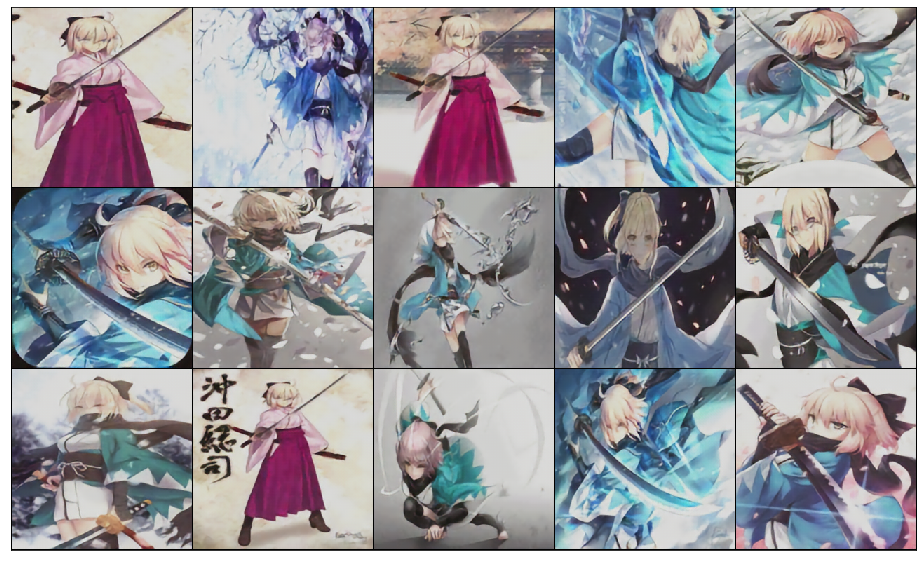

In [11]:
plt.figure(figsize=(20, 10))
show(make_grid(valid_reconstructions.cpu().data[:15,:,:,:], nrow=5, normalize=True))

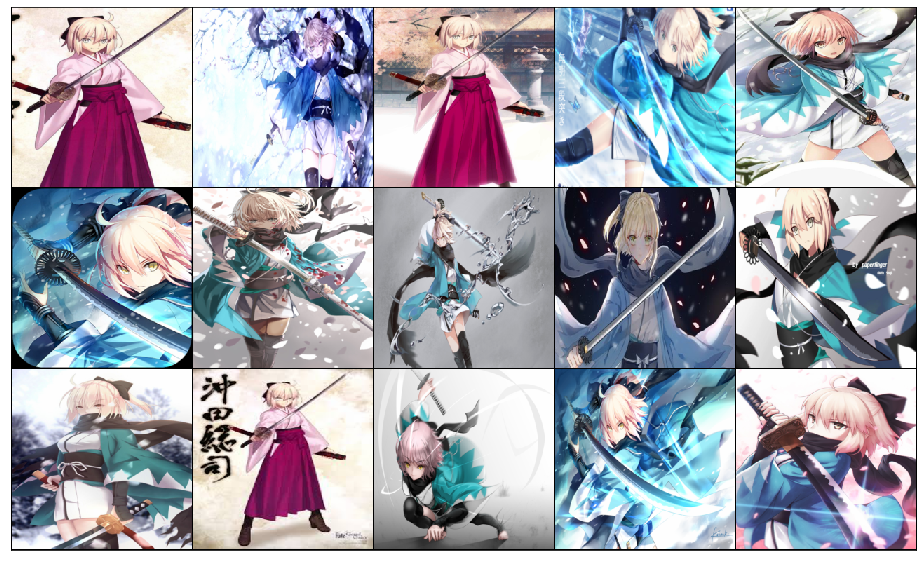

In [12]:
plt.figure(figsize=(20, 10))
show(make_grid(valid_originals.cpu()[:15,:,:,:], nrow=5, normalize=True))